<a href="https://colab.research.google.com/github/ShivenTripathi/CS786-Computational-Cognitive-Science/blob/main/Assignments/190816_CS786_Assn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS786
## Assignment 1
## Name: Shiven Tripathi
## Roll No.: 190816

### Code is also available at:

[190816_CS786_Assn_1.ipynb](https://colab.research.google.com/drive/1aP5-SN0Gxt2kenroXuHMUzRQNPOq2Qn2?usp=sharing)

(Google Colab Notebook)

In [ ]:
#For numerical computations
import numpy as np
np.random.seed(100)
import pandas as pd
import random

#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sn

#For image manipulation, used in deskew operation
from PIL import Image

#utilities 
from copy import deepcopy
from tqdm import tqdm

#For MNIST dataset
from tensorflow import keras

!pip install brian2
from brian2 import *

!pip install neurodynex3
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

#For calculation of classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from scipy.ndimage import interpolation

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# Q1.

Following code cell consists of 7 functions to make and use our Hopfield Network.

* Utility Functions:

  1. reverse_map_indices 
  2. sign

* Main functions:

  1. get_patterns
  2. calculate_weights
  3. network_evolution
  4. perturb_pattern
  5. compute_overlap

In [ ]:
def reverse_map_indices(idx, pattern_size):
  
  """
  converts flattened indices to square 2d
  """

  return int(idx/pattern_size), idx%pattern_size

def sign(Z):
    
  """
  same as signum function but all 0s converted to 1
  """

  return 2*(Z>=0) - 1

def get_patterns(pattern_size, n_patterns):
  
  """
  creates n_patterns of size pattern_size*pattern_size, consisting of +1,-1 
  """

  pattern_list=[]
  for p in range(n_patterns):
    neurons=np.array([[0]*pattern_size]*pattern_size)
    for i in range(pattern_size):
      for j in range(pattern_size):
        if(np.random.rand()>0.5):
          neurons[i][j]=1
        else:
          neurons[i][j]=-1
    pattern_list.append(neurons)

  return pattern_list

def calculate_weights(pattern_list, pattern_size):
  
  """
  computes weights using list of patterns
  """

  weights=np.array([[0]*pattern_size**2]*pattern_size**2)
  for p in range(len(pattern_list)):
    for i in range(pattern_size**2):
      i1,j1=reverse_map_indices(i,pattern_size)
      for j in range(pattern_size**2):
        i2,j2=reverse_map_indices(j,pattern_size)
        weights[i][j]+=pattern_list[p][i1][j1]*pattern_list[p][i2][j2]
  np.fill_diagonal(weights, 0)

  return weights/pattern_size**2  

def network_evolution(S0, weights, t_step):
    
    """
    iterates initial states S through t_steps using weights computed for pattern_list
    """

    S_list = [S0]    
    for t_step in range(1, t_step):
        s_vect = S_list[-1].flatten()
        state = sign(np.sum(weights*s_vect, axis=1))
        S_list.append(state.reshape(S0.shape))

    return S_list

def perturb_pattern(pattern, nflips):
  
  """
  randomly flips 'nflips' neuron in a pattern
  """

  fliplocs= np.random.randint(0, len(pattern)**2-1,nflips)
  for f in fliplocs:
    i,j = reverse_map_indices(f,len(pattern))
    pattern[i][j]=-pattern[i][j]

  return pattern

def compute_overlap(pattern1, pattern2):

    """
    computes overlap between 2 patterns (neuron wise dot)
    """

    shape1 = pattern1.shape
    if shape1 != pattern2.shape:
        raise ValueError("patterns are not of equal shape")
    dot_prod = np.dot(pattern1.flatten(), pattern2.flatten())

    return float(dot_prod) / (np.prod(shape1))

In [ ]:
def experiment(pattern_size=4, n_patterns=4,nflips=3,nstates=4,display=False, reference_idx=0):
  
  """
  Runs one experiment on Hopfield Network using above defined functions 
  and returns a cache containing experiment parameters and accuarcy.
  Also, plots states across time steps
  """

  plist = get_patterns(pattern_size,n_patterns)

  cue = deepcopy(plist)

  S = perturb_pattern(cue[0],nflips)
  wghts = calculate_weights(plist, pattern_size)

  state_list=network_evolution(S,wghts,nstates)
    
  if display:
    plot_tools.plot_pattern_list(plist)
    plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx, suptitle="Network dynamics")

  mlist=[]
  for ref_state in state_list:
    mlist.append(round(compute_overlap(ref_state,plist[reference_idx]),3))

  cache={
      'pattern_size':pattern_size,
      'n_patterns':n_patterns,
      'nflips':nflips,
      'nstates':nstates,
      'state_list':state_list,
      'plist':plist,
      'mlist':mlist
  }

  return cache

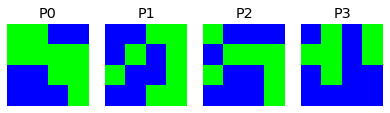

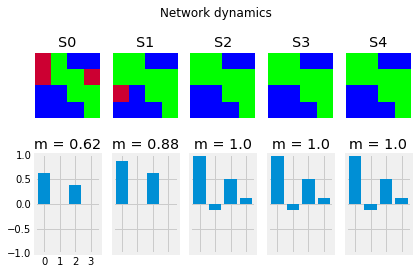

In [ ]:
cache=experiment(pattern_size=4, n_patterns=4,nflips=3,nstates=5,display=True)

# Q2.

Following code cells run multiple experiments, varying certain parameters to observe their relation to accuracy on the Hopfield task.


In [ ]:
def experimenter(pattern_size,max_perturb,n_patterns, n_states,iterations=5):
  
   """
   Creates a plot of multiple experiments, for various perturbations vs mscore for multiple n_patterns
   Also, for each perturbation, runs the experiment for multiple iterations to remove randomness
   """

   x=np.arange(1,max_perturb+1)
   labels=[]
   for j in tqdm(range(5,n_patterns,10)):
     y=[]
     for i in x:
       ytemp=[]
       for k in range(iterations):
        ytemp.append( experiment(pattern_size=pattern_size,n_patterns=j,nflips=i,nstates=n_states)['mlist'][-1]) 
       y.append(np.mean(ytemp))
     labels.append(str(j)+' patterns')
     plt.plot(x,y,linewidth=0.8)
   plt.legend(labels, loc='upper right')
   plt.xlabel('Perturbations')
   plt.ylabel('Accuracy')

### Model's capacity to retrieve information as a function of informativeness of the cues.

General trend is as the informativeness reduces due to more flips, the model's accuracy reduces.

Here: 

Neurons: 100

and every datapoint is iterated through 5 iterations to reduce randomness.

100%|██████████| 5/5 [14:45<00:00, 177.20s/it]


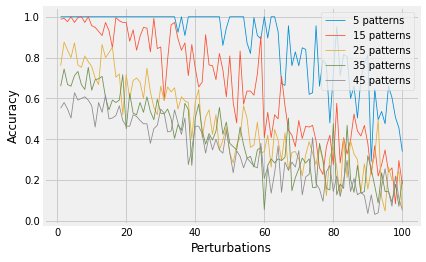

In [ ]:
experimenter(pattern_size=10, max_perturb= 100, n_patterns=50, n_states=5,iterations=5)

Same as above, but no effort to remove the randomness.

100%|██████████| 5/5 [02:52<00:00, 34.58s/it]


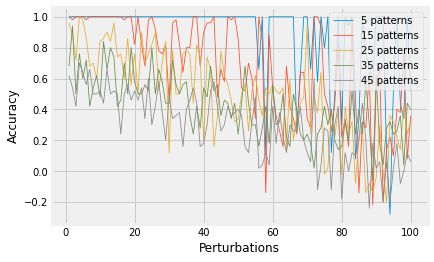

In [ ]:
experimenter(pattern_size=10, max_perturb= 100, n_patterns=50, n_states=5,iterations=1)

In [ ]:
def experimenter2(pattern_size,perturb,n_patterns, n_states):
  
   """
   Creates a plot of multuple experiments, for various number of patterns 
   and the mscore metric of accuracy
   The number of neurons and perturbations in intitial state are kept fixed
   """
   
   x=np.arange(2,n_patterns+1,1)
   y=[]
   labels=['100 Neurons\n10 flips']
   for i in x:
      y.append( experiment(pattern_size=pattern_size,n_patterns=i,nflips=perturb,nstates=n_states)['mlist'][-1]) 
   plt.plot(x,y)
   plt.legend(labels, loc='upper right')
   plt.xlabel('Number of Patterns')
   plt.ylabel('m score')

### Model's capacity to retrieve information as a function of number of patterns used to compute weights.

No clear general trend is observable with a lot of local maxima being observed.

Here:

Neurons: 100

Number of random flips: 10


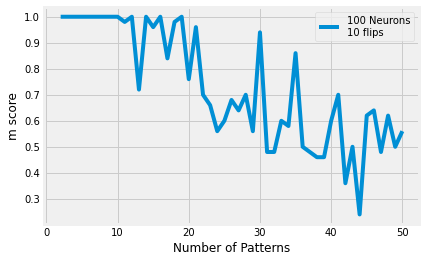

In [ ]:
experimenter2(pattern_size=10, perturb= 20, n_patterns=50, n_states=5)

In [ ]:
def experimenter3(max_pattern_size,perturb,n_patterns, n_states):
  
   """
   Creates a plot of multuple experiments, for various sizes of patterns 
   and the mscore metric of accuracy
   The number of patterns and perturbations in intitial state are kept fixed
   """
   
   x=np.arange(4,max_pattern_size+1,1)
   y=[]
   labels=['5 Patterns\n10 flips']
   for i in x:
      y.append( experiment(pattern_size=i,n_patterns=n_patterns,nflips=perturb,nstates=n_states)['mlist'][-1]) 
   plt.plot(x,y)
   plt.legend(labels, loc='upper right')
   plt.xlabel('Size of pattern')
   plt.ylabel('m score')

### Model's capacity to retrive information as a function of size of pattern.

I do not think keeping the number of flips constant was a very smart decision since for small patterns the flips are too large to recover from and for the larger patterns it does not make much of a difference. Probably from this graph we can take that there is a maximum of percentage of flips w.r.t. pattern size, till which the model is able to accurately retrieve information.

Here: 

No. of patterns: 5

No. of random flips: 10

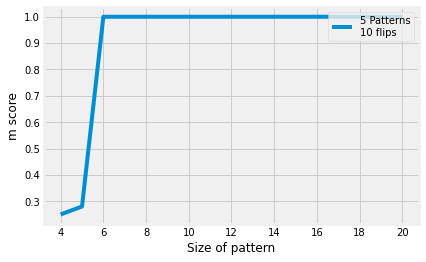

In [ ]:
experimenter3(max_pattern_size=20,perturb=10,n_patterns=5, n_states=5)

# Q3.

Following code cell uses the MNIST dataset available at keras.datasets and through preprocessing steps, converts it to the kind of patterns on which a Hopfield Network may be used for classification.

  * Preprocessing steps used:
    
    1. Deskew
    2. Crop
    3. Threshold 

In [ ]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

def moments(image):

    """
    Source: https://fsix.github.io/mnist/Deskewing.html
    """
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix

    return mu_vector, covariance_matrix

def deskew(image):
    
    """
    Source: https://fsix.github.io/mnist/Deskewing.html
    """
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)

    return interpolation.affine_transform(image,affine,offset=offset)

def MNISTprocessor(index,train, pattern_size=14, threshold=86):

  """
  For an index mapping to an image in MNIST dataset, this function deskews, 
  crops if pattern_size is 14 and converts it into +1,-1 neurons 
  with a threshold of 'threshold'.

  The default value for the pattern_size and threshold were borrowed from:

  Belyaev, Maksim & Velichko, Andrei. (2020). 
  Classification of handwritten digits using the Hopfield network. 
  IOP Conference Series: Materials Science and Engineering. 
  862. 052048. 10.1088/1757-899X/862/5/052048. 
  """
  if train is True: 
    im=deskew(x_train[index])
  else:
    im=deskew(x_test[index])

  if pattern_size is 14:
    im=im[7:21,7:21]

  im=im>threshold
  im=im.astype(int)
  im[im==0]=-1
  
  return im

# Q4.

Following code cell contains utility functions to run classification task on MNIST dataset using Hopfield Network

  1. get_patterns_MNIST_memory
  2. get_patterns_MNIST_testset
  3. get_patterns_MNIST
  4. get_prediction

In [ ]:
def get_patterns_MNIST_memory(pattern_size=14,n_patterns=2, memThreshold=86):
  
  """
  Returns n_patterns per class from x_train and y_train
  Uses memThreshold when processing to convert to +1,-1
  """

  pattern_list=[]
  for i in range(num_classes):
    indices=random.sample(list(np.nonzero(y_train==i)[0]),n_patterns)
    for j in indices:
      pattern_list.append(MNISTprocessor(j,True,pattern_size,memThreshold))

  return pattern_list

def get_patterns_MNIST_testset(pattern_size=14, testsize=1000, testThreshold=38):
  
  """
  Returns test set containing 'testsize' items from x_test and y_test
  Uses testThreshold when processing to convert to +1,-1.
  Note that we are using different thresholds for the memory patterns 
  and the testing patterns.
  """

  xtest,ytest=[],[]
  for i in range(testsize):
    xtest.append(MNISTprocessor(i,False, pattern_size,testThreshold))
  ytest=y_test[:testsize]

  return xtest,ytest

def get_patterns_MNIST(pattern_size=14,n_patterns=2, testsize=1000, memThreshold=86, testThreshold=38):

  """
  Decorator function using above 2 function definitions.

  Returns pattern_list for storing in weights, and test dataset to run 
  experiment on after processing image using MNISTprocessor
  """

  plist=get_patterns_MNIST_memory(pattern_size,n_patterns, memThreshold)
  xtest,ytest=get_patterns_MNIST_testset(pattern_size, testsize, testThreshold)
  return plist,xtest,ytest 

def get_prediction(state, pattern_list, n_patterns = 2):

  """
  Returns predicted digit value by comparing with stored patterns 
  according to maximum overlap
  """

  max_overlap = 0
  pred = 0

  for i in range(len(pattern_list)):
    temp = compute_overlap(state, pattern_list[i])
    if temp > max_overlap:
      max_overlap = temp
      pred = i

  return pred//n_patterns

In [ ]:
def experimentMNIST(pattern_size=28, n_patterns=2,nstates=10,testsize=1000,memThreshold=86,testThreshold=38):

  """
  Returns confusion matrix after running MNIST classification task 
  on Hopfield Network.
  Uses above functions to compute weights using list of training patterns 
  and runs predictions on the test dataset.

  The code snippet calculating metrics: accuracy, precision, fscore was borrowed from:
  https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
  """

  plist,xtest,ytest = get_patterns_MNIST(pattern_size,n_patterns,testsize, memThreshold, testThreshold)
  wghts = calculate_weights(plist, pattern_size)
  ypred=[]

  for i in range(testsize):
    S=xtest[i]
    state_list=network_evolution(S,wghts,nstates)
    ypred.append(get_prediction(state_list[-1],plist,n_patterns=n_patterns))
  
  confusion = confusion_matrix(ytest, ypred)
  print('Confusion Matrix\n')
  print(confusion)

  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(ytest, ypred)))
  print('Micro Precision: {:.2f}'.format(precision_score(ytest, ypred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(ytest, ypred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(ytest, ypred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(ytest, ypred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(ytest, ypred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(ytest, ypred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(ytest, ypred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(ytest, ypred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(ytest, ypred, average='weighted')))

  print('\nClassification Report\n')
  print(classification_report(ytest, ypred))

  return confusion, plist,state_list

In [ ]:
confusion,plist,state_list=experimentMNIST(pattern_size=14, n_patterns=4,nstates=1,testsize=10000,memThreshold=86,testThreshold=38)

Confusion Matrix

[[ 886    3    0    2   17   40   16   10    5    1]
 [   0 1093    0    0    0    1    2    3   35    1]
 [  25   18  633   80   14    0   50  103   99   10]
 [   8   18   14  817    0   16   38   14   32   53]
 [  23   14   34   49  588    7   66   14   17  170]
 [  67    4    3  134    1  385   84   11  106   97]
 [ 126    5   36    1   16   16  739    2   16    1]
 [   9   26   13    5    3    6    0  913    7   46]
 [  44    2   36   45   21   25   92   32  478  199]
 [  36   12    6    8   30    2   17   36    5  857]]

Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.75
Macro Recall: 0.73
Macro F1-score: 0.73

Weighted Precision: 0.75
Weighted Recall: 0.74
Weighted F1-score: 0.73

Classification Report

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       980
           1       0.91      0.96      0.94      1135
           2       0.82      0.61      0.70      1

### The confusion matrix is plotted in the following 2 cells.

Notice how maximum peaks are along the diagonal indicating correct predictions.

Also, a huge peak is observed in predicting 1, indicating it is the easiest to correctly classify.

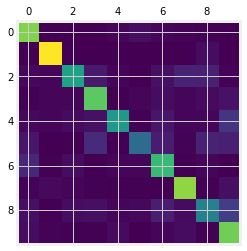

In [ ]:
plt.matshow(confusion)

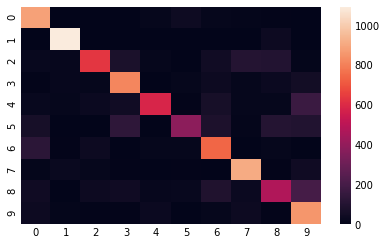

In [ ]:
df_cm = pd.DataFrame(confusion, range(num_classes), range(num_classes)) 
sn.heatmap(df_cm) 
plt.show()

## Results:

For the best Hopfield Model, using:

* pattern_size= 14 (Number of neurons = 14*14 = 196)
* n_patterns= 4 (number of patterns per class used for calculating weights)
* nstates= 1 (number of timesteps used for network evolution)
* testsize= 10000 (number of items in the testset)
* memThreshold= 86 (binarising threshold for images in the memory patterns)
* testThreshold= 38 (binarising threshold for images in the testset)

We obtain:

* Accuracy: 0.74
* Micro Precision: 0.74
* Micro Recall: 0.74
* Micro F1-score: 0.74

A CNN based Deep Learning model, can easily exceed **99%** Accuracy.

Source: Papers with Code, [Image Classification on MNIST](https://paperswithcode.com/sota/image-classification-on-mnist)

Merits: 

* Very fast, few shot learning

Demerits:

* Much worse performance compared to other methods.

### Patterns stored in the memory.

At this stage all the preprocessing steps have been completed.

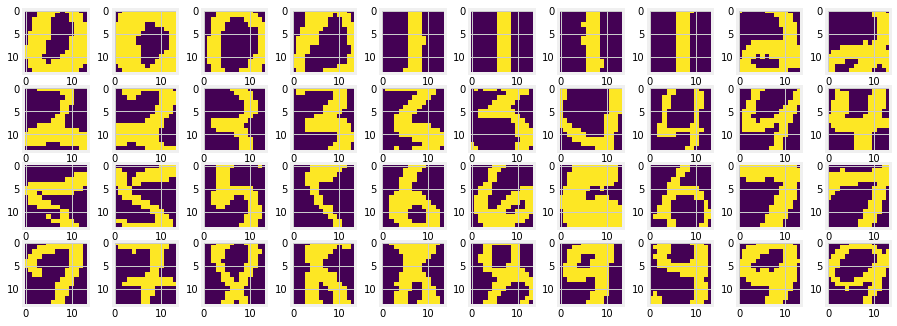

In [ ]:
fig=plt.figure(figsize=(np.shape(plist[0])))
columns = 10
rows = 10
for i in range(len(plist)):
    img =plist[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

### Testing on a random sample, on y_test[0]

Following code runs the prediction network, and after the test sample x_test[0] is displayed.

In [ ]:
confusion1,plist1,state_list1=experimentMNIST(pattern_size=14, n_patterns=4,nstates=1,testsize=1,memThreshold=86,testThreshold=38)

Confusion Matrix

[[1]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

           7       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



Class: [7]


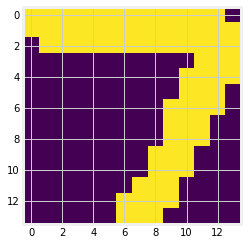

In [ ]:
x1,y1= get_patterns_MNIST_testset(pattern_size=14, testsize=1, testThreshold=38)

print("Class: "+str(y1))
plt.imshow(np.reshape(x1,(14,14)))

### Some other results, on varying the hyperparameters.

In [ ]:
confusion,plist,state_list=experimentMNIST(pattern_size=14, n_patterns=4,nstates=2,testsize=10000,memThreshold=86,testThreshold=38)

Confusion Matrix

[[ 845    2   41    1   12   10   54    1    6    8]
 [   0 1130    0    0    0    0    2    2    1    0]
 [  20  224  344  240   28    4   11  120   30   11]
 [   5  249   93  354    4   59   20  171   30   25]
 [  13   47   20    7  315    0   34   41   61  444]
 [  87   52   17   52    9  481   94   24   39   37]
 [  92   33   52    1  101   15  651    3    6    4]
 [   4  112   56   25   16    1    1  646    2  165]
 [  41   92   24   89   30   94   52   19  385  148]
 [  14   49   41    1   60    4    3   63   79  695]]

Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.59
Macro Recall: 0.58
Macro F1-score: 0.57

Weighted Precision: 0.59
Weighted Recall: 0.58
Weighted F1-score: 0.57

Classification Report

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       980
           1       0.57      1.00      0.72      1135
           2       0.50      0.33      0.40      1

In [ ]:
confusion,plist,state_list=experimentMNIST(pattern_size=14, n_patterns=4,nstates=3,testsize=10000,memThreshold=86,testThreshold=38)

Confusion Matrix

[[ 902    6    1   30    0   20    6   11    0    4]
 [   0 1133    0    0    0    0    0    2    0    0]
 [  91  265  311   33   10    0   31  250   22   19]
 [  64  285    6  482    1   27   19  111    7    8]
 [  61  111   82    4   69   12    8  283    0  352]
 [  83   97    6  469    0  110   26   81    2   18]
 [ 210  151  111   31    1   20  407   22    0    5]
 [   4  111    5    4    3    3    0  805    1   92]
 [ 114  101   53  158    2   37   19  361   62   67]
 [  35   91   18   12    2    5    1  465    0  380]]

Accuracy: 0.47

Micro Precision: 0.47
Micro Recall: 0.47
Micro F1-score: 0.47

Macro Precision: 0.54
Macro Recall: 0.45
Macro F1-score: 0.40

Weighted Precision: 0.54
Weighted Recall: 0.47
Weighted F1-score: 0.41

Classification Report

              precision    recall  f1-score   support

           0       0.58      0.92      0.71       980
           1       0.48      1.00      0.65      1135
           2       0.52      0.30      0.38      1

In [ ]:
confusion,plist,state_list=experimentMNIST(pattern_size=14, n_patterns=4,nstates=4,testsize=10000,memThreshold=86,testThreshold=38)

Confusion Matrix

[[ 927   16    1    7    0    7   14    8    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [ 137  279  363   25    0    1   15  210    1    1]
 [  48  646    6  184    3   35   12   73    2    1]
 [ 195  165   42    4    0    1   18  301    9  247]
 [ 158  443    0   20    3   95   20   99    4   50]
 [ 311  208   13    4    1    6  401   10    1    3]
 [  25  255    5    0    2    0    0  644    5   92]
 [ 188  348   32   70    0   11   27  220   36   42]
 [ 115  135    6    1    0    0    3  430   15  304]]

Accuracy: 0.41

Micro Precision: 0.41
Micro Recall: 0.41
Micro F1-score: 0.41

Macro Precision: 0.47
Macro Recall: 0.40
Macro F1-score: 0.34

Weighted Precision: 0.47
Weighted Recall: 0.41
Weighted F1-score: 0.35

Classification Report

              precision    recall  f1-score   support

           0       0.44      0.95      0.60       980
           1       0.31      1.00      0.48      1135
           2       0.78      0.35      0.48      1

In [ ]:
confusion,plist,state_list=experimentMNIST(pattern_size=14, n_patterns=4,nstates=5,testsize=10000,memThreshold=86,testThreshold=38)

Confusion Matrix

[[ 937   17    3    0    0    0    0    0    0   23]
 [   0 1133    0    2    0    0    0    0    0    0]
 [ 232  363    3  374   29    0    1    1    1   28]
 [ 162  513    0  290    0    0    1    2    0   42]
 [ 176   67    0  137  157    0    0    1    0  444]
 [ 272  265    2  109    6    3    6    8    0  221]
 [ 519  207    2   19   23    0   26    0    2  160]
 [  44  183    0  620    1    0    0  106    0   74]
 [ 166  183    0  363   41    0    1    0    0  220]
 [ 102   54    0  190   70    0    0    1    0  592]]

Accuracy: 0.32

Micro Precision: 0.32
Micro Recall: 0.32
Micro F1-score: 0.32

Macro Precision: 0.46
Macro Recall: 0.31
Macro F1-score: 0.22

Weighted Precision: 0.46
Weighted Recall: 0.32
Weighted F1-score: 0.22

Classification Report

              precision    recall  f1-score   support

           0       0.36      0.96      0.52       980
           1       0.38      1.00      0.55      1135
           2       0.30      0.00      0.01      1

# References:

1.   Belyaev, Maksim & Velichko, Andrei. (2020). 
  Classification of handwritten digits using the Hopfield network. 
  IOP Conference Series: Materials Science and Engineering. 
  862.052048. 10.1088/1757-899X/862/5/052048. 

2.    [Confusion Matrix for Your Multi-Class Machine Learning Model](https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826)

3.  [Deskewing](https://fsix.github.io/mnist/Deskewing.html)

4. Nisheeth Srivastava, *Computational Cognitive Science*, 2021, Lecture 5, "Neurons to Cognition" 

5. Papers with Code, [Image Classification on MNIST](https://paperswithcode.com/sota/image-classification-on-mnist)

# Acknowledgement:

I am thankful to my peers Atharv, Mohit in this course who helped me in debugging some of the graphing code by sharing their results and discussing strategies for parameter tuning.

## EXTRA

### Following code benchmarks the first experiment graph of Q2 for the Neurodynex 3 library.

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

In [ ]:
def libExperiment(pattern_size=4, n_patterns=4,nflips=3,nstates=4,reference_idx=0):
  
  """
  Runs one experiment on Hopfield Network using above neurodynex3 implementation 
  and returns accuarcy (of overlap).
  Also, plots states across time steps
  """

  hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
  factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
  checkerboard = factory.create_checkerboard()
  pattern_list = [checkerboard]
  pattern_list.extend(factory.create_random_pattern_list(nr_patterns=n_patterns, on_probability=0.5))
  hopfield_net.store_patterns(pattern_list)
  noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=nflips)
  hopfield_net.set_state_from_pattern(noisy_init_state)
  states = hopfield_net.run_with_monitoring(nr_steps=nstates)
  states_as_patterns = factory.reshape_patterns(states)

  mlist=[]
  for ref_state in states:
    mlist.append(round(compute_overlap(ref_state,pattern_list[reference_idx].reshape(pattern_size**2,)),3))

  return mlist

def libExperimenter(pattern_size,max_perturb,n_patterns, n_states):
   
   """
   Creates a plot of multiple experiments, for various perturbations vs mscore 
   for multiple n_patterns
   """
   x=np.arange(1,max_perturb+1)
   labels=[]
   for j in tqdm(range(5,n_patterns,10)):
     y=[]
     for i in x:
       y.append( np.max(libExperiment(pattern_size=pattern_size,n_patterns=j,nflips=i,nstates=n_states)))
     labels.append(str(j)+' patterns')
     plt.plot(x,y)
   plt.legend(labels, loc='upper right')
   plt.xlabel('Perturbations')
   plt.ylabel('Accuracy')

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


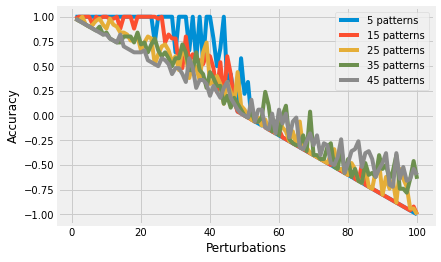

In [ ]:
libExperimenter(pattern_size=10, max_perturb= 100, n_patterns=50, n_states=5)